In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 18.4 MB/s eta 0:00:0000:0100:01


In [1]:
!pip install cupy-cuda12x

  Using cached fastrlock-0.8.2-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl.metadata (9.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 MB 45.8 MB/s eta 0:00:00:00:0100:01
Using cached fastrlock-0.8.2-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl (51 kB)


In [23]:
import pandas as pd
import optuna
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt

import cupy as cp
from xgboost import XGBRegressor
import xgboost

from utils import *


optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
# Suppress pandas warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
versions = [
            'classic',
            'stations_basic', 
            'stations_weighted_all',
            'stations_weights_inverse',
            'stations_weights_gaussian',
            'stations_weights_logarithmic',
            'stations_weights_linear'
                ]

n_trials= 25
random_state = 42
test_size = 0.2

model_classes = [
    XGBRegressor,    
]

In [3]:
df_scores = pd.DataFrame(columns=['version', 'model', 'r2', 'mse', 'mae', 'best_params', 'validation_mae'])
studies = {}

In [4]:
for version in versions:
    for model_class in model_classes:
        print("="*50)
        print(f'{version} - {model_class.__name__}')
        X_train, X_test, y_train, y_test  = prepare_data(version=version, test_size=test_size, random_state=random_state)
        # Define the metric function for optimization
        metric_function = mean_absolute_error
        # Create the objective function with additional parameters
        objective = create_objective_function(X_train, y_train, metric_function, model_class)
        study = optuna.create_study(direction="minimize", study_name=f"{version}_{model_class.__name__}")
        
            
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True,gc_after_trial=True)  
        model = model_class(**study.best_params, random_state=random_state)
            
        scaler = MaxAbsScaler()
        # Fit the scaler on the training set and transform the training and testing sets
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_train_scaled = cp.array(X_train_scaled)
        X_test_scaled = cp.array(X_test_scaled)
        y_train = cp.array(y_train)
            
        model.fit(X_train_scaled, y_train)
        
        # evaluate the model
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        validation_mae = study.best_value
        new_row = {'version': version, 'model': model_class.__name__, 'r2': r2, 'mse': mse, 'mae': mae, 'best_params': study.best_params, 'validation_mae': validation_mae}
        df_scores = pd.concat([df_scores, pd.DataFrame([new_row])], ignore_index=True)
        # save the study
        studies[f'{version}_{model_class.__name__}'] = study

        

classic - XGBRegressor


  0%|          | 0/25 [00:00<?, ?it/s]

stations_basic - XGBRegressor


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:20:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

stations_weighted_all - XGBRegressor


  0%|          | 0/25 [00:00<?, ?it/s]

stations_weights_inverse - XGBRegressor


  0%|          | 0/25 [00:00<?, ?it/s]

stations_weights_gaussian - XGBRegressor


  0%|          | 0/25 [00:00<?, ?it/s]

stations_weights_logarithmic - XGBRegressor


  0%|          | 0/25 [00:00<?, ?it/s]

stations_weights_linear - XGBRegressor


  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
df_scores.sort_values(by='mae', ascending=True, inplace=False)


version         model        r2           mse  \
6       stations_weights_linear  XGBRegressor  0.788898  30439.061746   
3      stations_weights_inverse  XGBRegressor  0.790968  30140.569840   
4     stations_weights_gaussian  XGBRegressor  0.789009  30423.042082   
5  stations_weights_logarithmic  XGBRegressor  0.780932  31587.756342   
0                       classic  XGBRegressor  0.783911  31158.080454   
2         stations_weighted_all  XGBRegressor  0.788506  30495.553464   
1                stations_basic  XGBRegressor  0.781359  31526.067564   

          mae                                        best_params  \
6  101.321920  {'n_estimators': 1100, 'learning_rate': 0.0157...   
3  101.480831  {'n_estimators': 700, 'learning_rate': 0.06032...   
4  101.933963  {'n_estimators': 900, 'learning_rate': 0.06229...   
5  102.276471  {'n_estimators': 900, 'learning_rate': 0.03333...   
0  102.291392  {'n_estimators': 800, 'learning_rate': 0.01513...   
2  102.600230  {'n_estimators': 1200, 'learning_rate': 0.0144...   
1  102.809101  {'n_estimators': 1000, 'learning_rate': 0.0669...   

   validation_mae  
6      113.840505  
3      114.650424  
4      114.377542  
5      114.277807  
0      115.305035  
2      114.929505  
1      110.762425

In [7]:
# save studies object
add_name = '_'.join(versions)
import pickle
with open(f'studies/studies_xgboost.pkl', 'wb') as f:
    pickle.dump(studies, f)
# save results
df_scores.to_csv(f'results/results_xgboost.csv', index=False)

In [9]:
study_ = studies['stations_weights_linear_XGBRegressor']
study.best_params

{'n_estimators': 1100,
 'learning_rate': 0.01576253164684871,
 'max_depth': 22,
 'min_child_weight': 4,
 'subsample': 0.5051200702138716,
 'colsample_bytree': 0.6569239664184245,
 'reg_alpha': 0.12392462946123958,
 'reg_lambda': 7.481477787444512}

In [10]:
 X_train, X_test, y_train, y_test  = prepare_data(version='stations_weights_linear', test_size=test_size, random_state=random_state)

In [15]:
model = XGBRegressor( random_state=random_state,tree_method="hist",
                device= "cuda",**study.best_params)
            
scaler = MaxAbsScaler()
# Fit the scaler on the training set and transform the training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = cp.array(X_train_scaled)
X_test_scaled = cp.array(X_test_scaled)
y_train = cp.array(y_train)

In [16]:
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6569239664184245, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01576253164684871, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=22, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

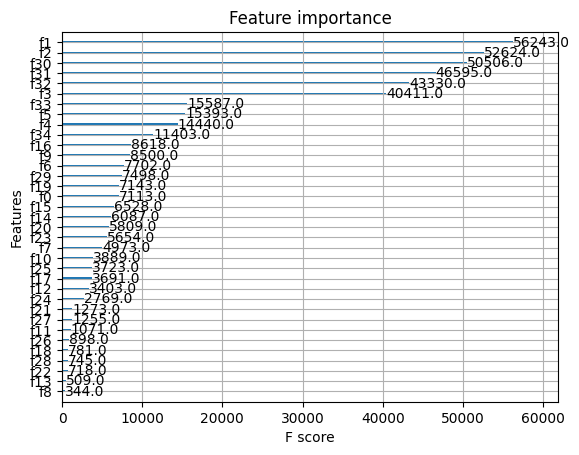

In [19]:
xgboost.plot_importance(model)

Text(0.5, 0, 'Xgboost Feature Importance')

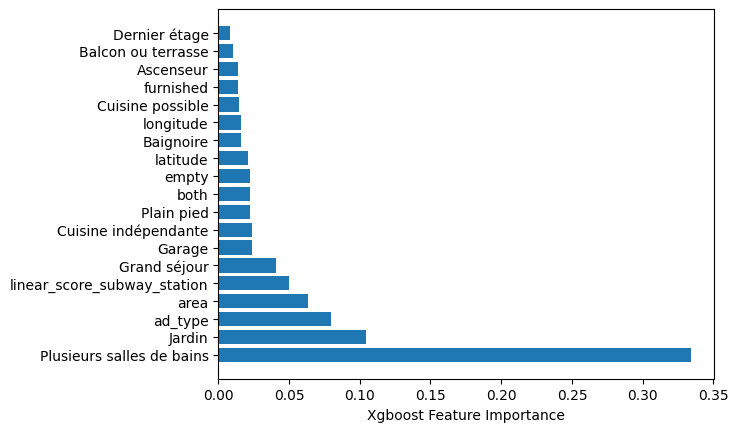

In [30]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-1:15:-1], model.feature_importances_[sorted_idx][-1:15:-1])
plt.xlabel("Xgboost Feature Importance")

In [21]:
sorted_id

array([18, 11, 10, 17,  9, 16,  5, 32, 25,  4, 15, 33, 24, 14, 30, 31, 12,
       19, 29,  6, 21,  2, 23,  1,  7,  8, 13, 28, 22, 20, 34,  3,  0, 26,
       27])